# Imports

In [1]:
import os
import logging
import pandas as pd
import datetime
import numpy as np
import subprocess

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from matplotlib.pyplot import Polygon
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter, MinuteLocator
import matplotlib.ticker as ticker

import ipywidgets as widgets
from ipywidgets import interact

from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, LinearAxis, Range1d
from bokeh.palettes import Spectral10

from IPython.display import Image

try:
    from PT3S import dxAndMxHelperFcts
except:
    import dxAndMxHelperFcts

try:
    from PT3S import Rm
except:
    import Rm

In [2]:
import importlib

In [3]:
importlib.reload(dxAndMxHelperFcts)

<module 'dxAndMxHelperFcts' from 'c:\\users\\wolters\\3s\\pt3s\\dxAndMxHelperFcts.py'>

# Logging

In [4]:
logger = logging.getLogger()  

logFileName= r"Example3.log" 

loglevel = logging.DEBUG
logging.basicConfig(filename=logFileName
                        ,filemode='w'
                        ,level=loglevel
                        ,format="%(asctime)s ; %(name)-60s ; %(levelname)-7s ; %(message)s")    

fileHandler = logging.FileHandler(logFileName)     

logger.addHandler(fileHandler)

consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(logging.Formatter("%(levelname)-7s ; %(message)s"))
consoleHandler.setLevel(logging.INFO)
logger.addHandler(consoleHandler)

# Read Model and Results

In [5]:
dbFilename="DistrictHeating"
dbFile=os.path.join(os.path.dirname(os.path.abspath(dxAndMxHelperFcts.__file__))
                    +'/Examples/'
                    +dbFilename
                    +'.db3'
)

In [6]:
m=dxAndMxHelperFcts.readDxAndMx(dbFile=dbFile                                 
                                ,preventPklDump=True
                              #  ,maxRecords=-1
)

INFO    ; Dx.__init__: dbFile (abspath): c:\users\wolters\3s\pt3s\Examples\DistrictHeating.db3 exists readable ...
INFO    ; dxAndMxHelperFcts.readDxAndMx: 
+..\Examples\DistrictHeating.db3 is newer than
+..\Examples\WDDistrictHeating\B1\V0\BZ1\M-1-0-1.1.MX1:
+SIR 3S' dbFile is newer than SIR 3S' mx1File
+in this case the results are maybe dated or (worse) incompatible to the model
INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDDistrictHeating\B1\V0\BZ1\M-1-0-1.1.MXS reading ...
INFO    ; dxWithMx.__init__: DistrictHeating: processing dx and mx ...


In [7]:
m.V3_AGSN.shape,m.dfAGSN.shape

((537, 38), (528, 10))

# Longitudinal Sections

In [8]:
m.V3_AGSN.reset_index().rename(columns={'level_0':'OBJTYPE','level_1':'OBJID'})

,index,OBJTYPE,OBJID,Pos,pk,tk,LFDNR,NAME,XL,compNr,...,"('TMIN', 'KNOT~*~*~*~H', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-13 23:00:00'))_n","('TMAX', 'KNOT~*~*~*~H', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-13 23:00:00'))_n","('STAT', 'KNOT~*~*~*~T', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-12 23:00:00'))_n","('TIME', 'KNOT~*~*~*~T', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-12 23:00:00'))_n","('TMIN', 'KNOT~*~*~*~T', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-13 23:00:00'))_n","('TMAX', 'KNOT~*~*~*~T', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-13 23:00:00'))_n",PH_n,T_n,H_n,direction
0,0,ROHR,5691533564979419761,-1,5755933101669454049,5755933101669454049,1.0,Längsschnitt,0,1,...,5.024506,5.932653,90.0,90.0,90.0,90.0,4.878388,90.0,5.024506,1
1,0,ROHR,5691533564979419761,0,5755933101669454049,5755933101669454049,1.0,Längsschnitt,0,1,...,5.024506,5.932653,90.0,90.0,90.0,90.0,4.878388,90.0,5.024506,1
2,1,ROHR,5048873293262650113,1,5755933101669454049,5755933101669454049,1.0,Längsschnitt,0,1,...,5.024687,5.927407,89.998016,89.998016,89.998016,89.998932,4.800117,89.998016,5.024687,1
3,2,ROHR,5715081934973525403,2,5755933101669454049,5755933101669454049,1.0,Längsschnitt,0,1,...,5.025103,5.9212,89.995605,89.995605,89.995605,89.99765,4.698539,89.995605,5.025103,-1
4,3,ROHR,5413647981880727734,3,5755933101669454049,5755933101669454049,1.0,Längsschnitt,0,1,...,5.025112,5.916106,89.993744,89.993744,89.993744,89.996674,4.629901,89.993744,5.025112,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,523,ROHR,4621030304810285220,39,4868980900521118307,4868980900521118307,3.0,"Längsschnitt in bar,B",2,1,...,3.464544,4.091011,59.867401,59.867401,59.867401,60.171204,1.208033,59.867401,3.464544,-1
533,524,ROHR,5046251450517706156,40,4868980900521118307,4868980900521118307,3.0,"Längsschnitt in bar,B",2,1,...,3.465572,4.093916,59.871002,59.871002,59.871002,60.17334,1.196312,59.871002,3.465572,-1
534,525,ROHR,5478012163155701568,41,4868980900521118307,4868980900521118307,3.0,"Längsschnitt in bar,B",2,1,...,3.471704,4.110133,59.890289,59.890289,59.890289,60.184814,1.09261,59.890289,3.471704,-1
535,526,ROHR,4968402990875758821,42,4868980900521118307,4868980900521118307,3.0,"Längsschnitt in bar,B",2,1,...,3.477824,4.127234,59.908417,59.908417,59.908417,60.195557,1.018315,59.908417,3.477824,-1


In [17]:
#sorted(m.mx.dfVecAggs.index.to_list())

In [18]:
cols=m.V3_AGSN.columns.to_list()
colsErg=cols[cols.index('NAME_k')+1:]
colsErg

[('STAT',
  'QM',
  Timestamp('2023-02-12 23:00:00'),
  Timestamp('2023-02-12 23:00:00')),
 ('TIME',
  'QM',
  Timestamp('2023-02-12 23:00:00'),
  Timestamp('2023-02-12 23:00:00')),
 ('TMIN',
  'QM',
  Timestamp('2023-02-12 23:00:00'),
  Timestamp('2023-02-13 23:00:00')),
 ('TMAX',
  'QM',
  Timestamp('2023-02-12 23:00:00'),
  Timestamp('2023-02-13 23:00:00')),
 'QM',
 "('STAT', 'KNOT~*~*~*~PH', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-12 23:00:00'))_n",
 "('TIME', 'KNOT~*~*~*~PH', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-12 23:00:00'))_n",
 "('TMIN', 'KNOT~*~*~*~PH', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-13 23:00:00'))_n",
 "('TMAX', 'KNOT~*~*~*~PH', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-13 23:00:00'))_n",
 "('STAT', 'KNOT~*~*~*~H', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-12 23:00:00'))_n",
 "('TIME', 'KNOT~*~*~*~H', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-12 23:00:00'))_n",
 "('TMIN', 'KNOT~*~*~*~H', Time

In [19]:
for col in [col for col in colsErg if type(col)==tuple]:
    print(col)

('STAT', 'QM', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-12 23:00:00'))
('TIME', 'QM', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-12 23:00:00'))
('TMIN', 'QM', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-13 23:00:00'))
('TMAX', 'QM', Timestamp('2023-02-12 23:00:00'), Timestamp('2023-02-13 23:00:00'))


In [20]:
dfAGSN=m.V3_AGSN[
    (m.V3_AGSN['LFDNR']==1)
    &
    (m.V3_AGSN['XL']==1)
]
dfAGSN[['XL','NAME_i','NAME_k','nextNODE','compNr','LSum','QM','direction']]

,XL,NAME_i,NAME_k,nextNODE,compNr,LSum,QM,direction
88,1,V-E0,V-K1683S,V-E0,1,0.000000,287.090057,1
88,1,V-E0,V-K1683S,V-K1683S,1,15.351701,287.090057,1
89,1,V-K1683S,V-K1693S,V-K1693S,1,27.860648,287.090057,1
90,1,V-K2163S,V-K1693S,V-K2163S,1,34.126153,-287.090057,-1
91,1,V-K2043S,V-K2163S,V-K2043S,1,48.533695,-287.090057,-1
92,1,V-K2033S,V-K2043S,V-K2033S,1,62.049538,-287.090057,-1
93,1,V-K833S,V-K2033S,V-K833S,1,79.324254,-287.090057,-1
94,1,V-K833S,V-K843S,V-K843S,1,113.666420,287.090057,1
95,1,V-K843S,V-K853S,V-K853S,1,149.752335,287.090057,1
96,1,V-K853S,V-K863S,V-K863S,1,213.782486,287.090057,1


In [21]:
dfAGSNRL=m.V3_AGSN[
    (m.V3_AGSN['LFDNR']==1)
    &
    (m.V3_AGSN['XL']==2)
]
dfAGSNRL[['XL','NAME_i','NAME_k','nextNODE','compNr','LSum','QM','direction']]

,XL,NAME_i,NAME_k,nextNODE,compNr,LSum,QM,direction
132,2,R-E0,R-K4163S,R-K4163S,1,0.000000,-287.090057,-1
132,2,R-E0,R-K4163S,R-K4163S,1,15.351701,-287.090057,-1
133,2,R-K4163S,R-K4173S,R-K4173S,1,27.860648,-287.090057,-1
134,2,R-K4643S,R-K4173S,R-K4643S,1,34.126153,287.090057,1
135,2,R-K4523S,R-K4643S,R-K4523S,1,48.533695,287.090057,1
136,2,R-K4513S,R-K4523S,R-K4513S,1,62.049538,287.090057,1
137,2,R-K3313S,R-K4513S,R-K3313S,1,79.324254,287.090057,1
138,2,R-K3313S,R-K3323S,R-K3323S,1,113.666420,-287.090057,-1
139,2,R-K3323S,R-K3333S,R-K3333S,1,149.752335,-287.090057,-1
140,2,R-K3333S,R-K3343S,R-K3343S,1,213.782486,-287.090057,-1


# Plot

## Define Axes

In [22]:
def fyP(ax,offset=0):
    ax.spines["left"].set_position(("outward", offset))
    ax.set_ylabel('Druckhöhe in mlc')
    #ax.set_ylim(1,6)
    #ax.set_yticks(sorted(np.append(np.linspace(1,6,11),[])))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')

def fyM(ax,offset=60):
    Rm.pltLDSHelperY(ax)
    ax.spines["left"].set_position(("outward",offset))
    ax.set_ylabel('Massenstrom in t/h')
    #ax.set_ylim(500,550)
    #ax.set_yticks(sorted(np.append(np.linspace(500,550,11),[])))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')
    
def fyT(ax,offset=120):
    Rm.pltLDSHelperY(ax)
    ax.spines["left"].set_position(("outward",offset))
    ax.set_ylabel('Tempertatur in °C')
    #ax.set_ylim(85,95)
    #ax.set_yticks(sorted(np.append(np.linspace(0,95,11),[])))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')

## Non-interactive Plot

In [23]:
def plot():
                       
    fig, ax0 = plt.subplots(figsize=Rm.DINA3q)
    
    ax0.set_yticks(np.linspace(0, 10, 21))
    ax0.yaxis.set_ticklabels([])
    ax0.grid()

    #P
    ax1 = ax0.twinx()     
    fyP(ax1) 
    ax1.plot(dfAGSN['LSum'], dfAGSN['H_n'], color='red', label='H SL')
    ax1.plot(dfAGSNRL['LSum'], dfAGSNRL['H_n'], color='blue', label='H RL')
    
    #M
    ax2 = ax0.twinx()     
    fyM(ax2)
    ax2.step(dfAGSN['LSum'], dfAGSN['QM']*dfAGSN['direction'], color='orange', label='M SL')
    ax2.step(dfAGSNRL['LSum'], dfAGSNRL['QM']*dfAGSNRL['direction'], color='cyan', label='M RL',ls='--')
    
    #T
    ax3 = ax0.twinx() 
    fyT(ax3)
    ax3.plot(dfAGSN['LSum'], dfAGSN['T_n'], color='pink', label='T')
    
         
    ax0.set_title('Longitudinal Section for '+dbFilename)

    
    plt.show()

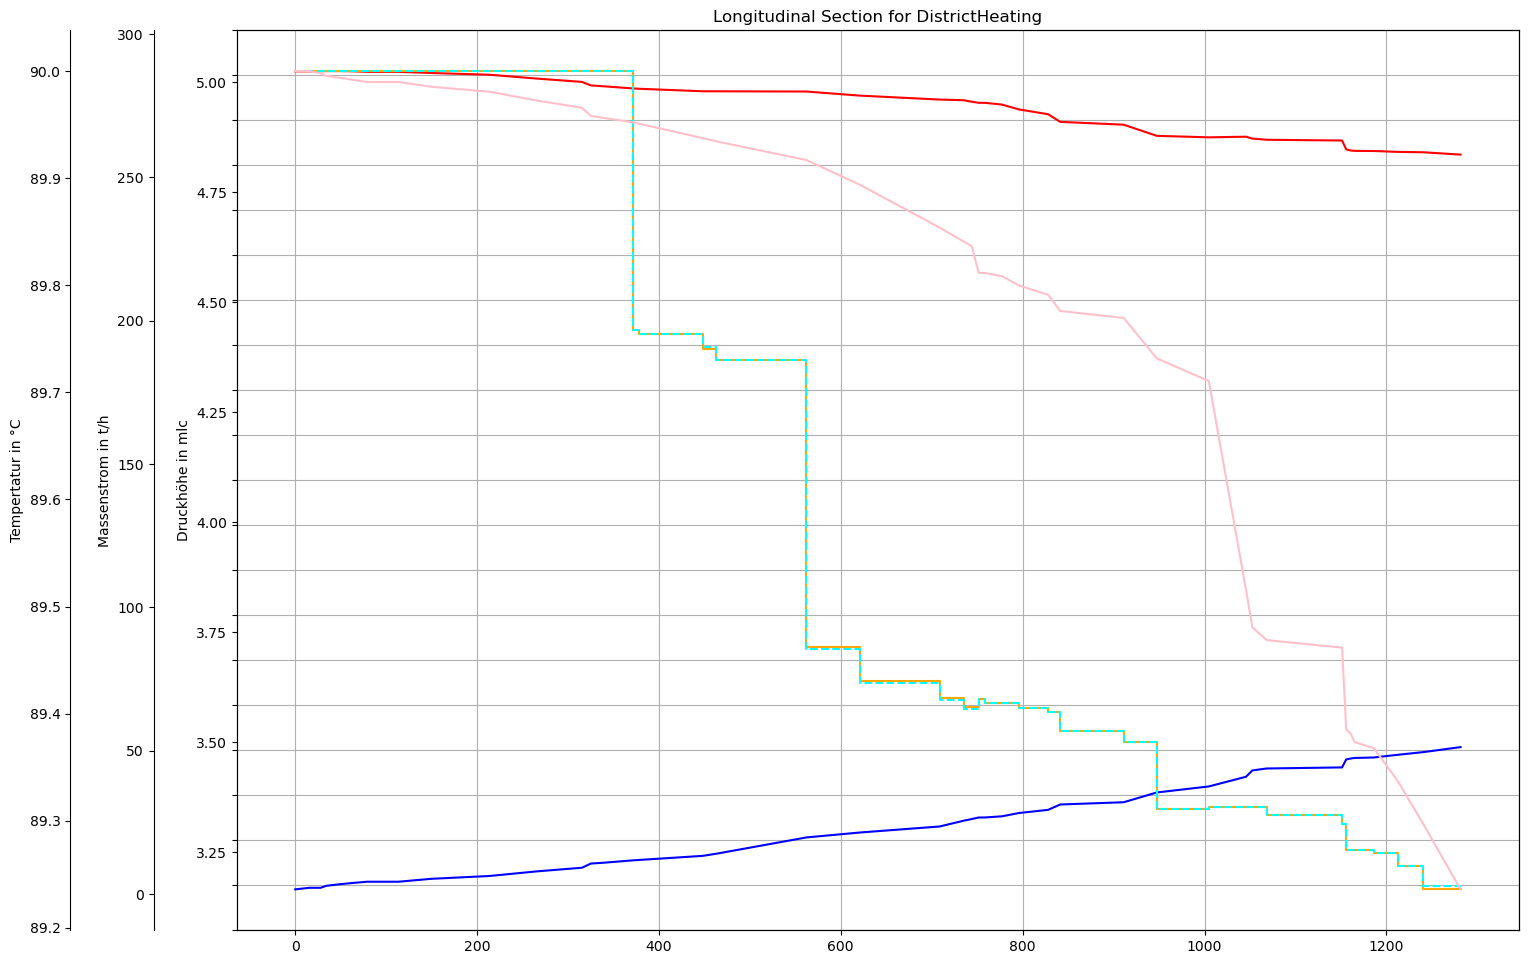

In [24]:
plot()